In [1]:
from kuramoto import Kuramoto
from kuramoto.nmf import *
from NNetwork import NNetwork as nn

import networkx as nx

In [2]:
NWS = nx.newman_watts_strogatz_graph(20000, 25, 0.67, seed = 42)
new_nodes = {e: n for n, e in enumerate(NWS.nodes, start=1)}
new_edges = [(new_nodes[e1], new_nodes[e2]) for e1, e2 in NWS.edges]
edgelist = []
for i in range(len(new_edges)):
    temp = [str(new_edges[i][0]), str(new_edges[i][1])]
    edgelist.append(temp)
NWS = nn.NNetwork()
NWS.add_edges(edgelist)

In [3]:
sampling_alg = 'pivot'

k = 50
ntwk = 'NWS'
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/NWS'

print('num nodes in NWS', len(NWS.nodes()))
print('num edges in NWS', len(NWS.get_edges()))

num nodes in NWS 20000
num edges in NWS 801938


num of subgraphs induced on k-paths: 2500
X.shape (2500, 2500)


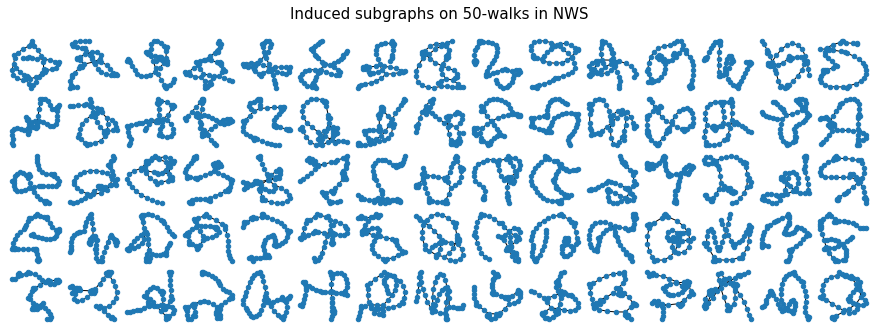

In [4]:
X, embs = NWS.get_patches(k = k, sample_size = 2500, skip_folded_hom = True)

display_graphs(title = 'Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path = save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance = False)

In [5]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 2500


In [6]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 7.5

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
2497,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2498,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False


In [7]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.0448


In [8]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [9]:
W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  2%|▊                                       | 19/1000 [00:00<00:05, 186.85it/s]

iteration 0, reconstruction error 17117.509754
iteration 10, reconstruction error 5720.685937
iteration 20, reconstruction error 5558.553668


  4%|█▌                                      | 38/1000 [00:00<00:05, 185.47it/s]

iteration 30, reconstruction error 4609.051438


  6%|██▎                                     | 57/1000 [00:00<00:05, 179.02it/s]

iteration 40, reconstruction error 4168.683851
iteration 50, reconstruction error 3915.142538
iteration 60, reconstruction error 3748.048122


  8%|███                                     | 75/1000 [00:00<00:05, 176.71it/s]

iteration 70, reconstruction error 3634.096837


  9%|███▋                                    | 93/1000 [00:00<00:05, 176.80it/s]

iteration 80, reconstruction error 3553.719357
iteration 90, reconstruction error 3495.761920
iteration 100, reconstruction error 3452.028325


 11%|████▎                                  | 111/1000 [00:00<00:05, 168.59it/s]

iteration 110, reconstruction error 3417.551947


 13%|████▉                                  | 128/1000 [00:00<00:06, 137.53it/s]

iteration 120, reconstruction error 3390.426056
iteration 130, reconstruction error 3368.589966


 15%|█████▋                                 | 147/1000 [00:00<00:05, 150.70it/s]

iteration 140, reconstruction error 3350.900657
iteration 150, reconstruction error 3336.552961


 16%|██████▎                                | 163/1000 [00:01<00:05, 153.07it/s]

iteration 160, reconstruction error 3324.736171
iteration 170, reconstruction error 3314.910354


 18%|███████▏                               | 184/1000 [00:01<00:04, 167.62it/s]

iteration 180, reconstruction error 3306.623048
iteration 190, reconstruction error 3299.427117
iteration 200, reconstruction error 3293.115687


 20%|███████▉                               | 204/1000 [00:01<00:04, 174.85it/s]

iteration 210, reconstruction error 3287.584226


 24%|█████████▌                             | 244/1000 [00:01<00:04, 180.76it/s]

iteration 220, reconstruction error 3282.601354
iteration 230, reconstruction error 3278.092552
iteration 240, reconstruction error 3273.923193
iteration 250, reconstruction error 3270.062873


 29%|███████████▏                           | 288/1000 [00:01<00:03, 194.15it/s]

iteration 260, reconstruction error 3266.385546
iteration 270, reconstruction error 3262.869157
iteration 280, reconstruction error 3259.475631
iteration 290, reconstruction error 3256.179571
iteration 300, reconstruction error 3252.962047


 33%|████████████▉                          | 331/1000 [00:01<00:03, 196.56it/s]

iteration 310, reconstruction error 3249.777140
iteration 320, reconstruction error 3246.567937
iteration 330, reconstruction error 3243.300104
iteration 340, reconstruction error 3239.944729


 35%|█████████████▋                         | 351/1000 [00:01<00:03, 197.38it/s]

iteration 350, reconstruction error 3236.504510


 37%|██████████████▍                        | 371/1000 [00:02<00:03, 194.06it/s]

iteration 360, reconstruction error 3233.004046
iteration 370, reconstruction error 3229.461917
iteration 380, reconstruction error 3225.944796


 39%|███████████████▏                       | 391/1000 [00:02<00:03, 192.48it/s]

iteration 390, reconstruction error 3222.493005
iteration 400, reconstruction error 3219.148924


 41%|████████████████                       | 412/1000 [00:02<00:03, 194.91it/s]

iteration 410, reconstruction error 3215.928844
iteration 420, reconstruction error 3212.861781
iteration 430, reconstruction error 3209.946528


 44%|█████████████████                      | 439/1000 [00:02<00:02, 212.21it/s]

iteration 440, reconstruction error 3207.189111
iteration 450, reconstruction error 3204.590800


 48%|██████████████████▊                    | 483/1000 [00:02<00:02, 208.99it/s]

iteration 460, reconstruction error 3202.163197
iteration 470, reconstruction error 3199.923148
iteration 480, reconstruction error 3197.822637
iteration 490, reconstruction error 3195.855377
iteration 500, reconstruction error 3194.020983


 53%|████████████████████▌                  | 528/1000 [00:02<00:02, 211.79it/s]

iteration 510, reconstruction error 3192.305545
iteration 520, reconstruction error 3190.712828
iteration 530, reconstruction error 3189.215909


 55%|█████████████████████▍                 | 550/1000 [00:02<00:02, 212.19it/s]

iteration 540, reconstruction error 3187.819264
iteration 550, reconstruction error 3186.516023


 57%|██████████████████████▎                | 572/1000 [00:03<00:02, 209.70it/s]

iteration 560, reconstruction error 3185.294116
iteration 570, reconstruction error 3184.139155
iteration 580, reconstruction error 3183.048436


 59%|███████████████████████▏               | 594/1000 [00:03<00:01, 206.07it/s]

iteration 590, reconstruction error 3182.007154


 62%|███████████████████████▉               | 615/1000 [00:03<00:01, 203.82it/s]

iteration 600, reconstruction error 3181.015270
iteration 610, reconstruction error 3180.067587
iteration 620, reconstruction error 3179.156556
iteration 630, reconstruction error 3178.283444


 64%|████████████████████████▉              | 638/1000 [00:03<00:01, 210.17it/s]

iteration 640, reconstruction error 3177.442250


 68%|██████████████████████████▌            | 681/1000 [00:03<00:01, 203.30it/s]

iteration 650, reconstruction error 3176.628281
iteration 660, reconstruction error 3175.839022
iteration 670, reconstruction error 3175.072916
iteration 680, reconstruction error 3174.331270


 72%|████████████████████████████▎          | 725/1000 [00:03<00:01, 209.25it/s]

iteration 690, reconstruction error 3173.613395
iteration 700, reconstruction error 3172.915254
iteration 710, reconstruction error 3172.237798
iteration 720, reconstruction error 3171.578912
iteration 730, reconstruction error 3170.937175


 77%|██████████████████████████████         | 772/1000 [00:03<00:01, 220.64it/s]

iteration 740, reconstruction error 3170.309072
iteration 750, reconstruction error 3169.693885
iteration 760, reconstruction error 3169.090709
iteration 770, reconstruction error 3168.502071
iteration 780, reconstruction error 3167.925868


 82%|███████████████████████████████▉       | 819/1000 [00:04<00:00, 221.17it/s]

iteration 790, reconstruction error 3167.363319
iteration 800, reconstruction error 3166.812469
iteration 810, reconstruction error 3166.273167
iteration 820, reconstruction error 3165.746312
iteration 830, reconstruction error 3165.231223


 87%|█████████████████████████████████▊     | 866/1000 [00:04<00:00, 222.57it/s]

iteration 840, reconstruction error 3164.728374
iteration 850, reconstruction error 3164.241669
iteration 860, reconstruction error 3163.768225
iteration 870, reconstruction error 3163.305583
iteration 880, reconstruction error 3162.852637


 93%|████████████████████████████████████▍  | 934/1000 [00:04<00:00, 212.35it/s]

iteration 890, reconstruction error 3162.408427
iteration 900, reconstruction error 3161.974731
iteration 910, reconstruction error 3161.549038
iteration 920, reconstruction error 3161.130778
iteration 930, reconstruction error 3160.721725


 98%|██████████████████████████████████████▏| 978/1000 [00:04<00:00, 209.19it/s]

iteration 940, reconstruction error 3160.322375
iteration 950, reconstruction error 3159.933025
iteration 960, reconstruction error 3159.554108
iteration 970, reconstruction error 3159.184754
iteration 980, reconstruction error 3158.824581


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 196.17it/s]


iteration 990, reconstruction error 3158.473259


###########################
Shape of W_true: (2500, 16)
###########################




  0%|                                          | 2/1000 [00:00<00:56, 17.66it/s]

iteration 0, reconstruction error 336315.001936


  1%|▌                                        | 14/1000 [00:00<00:43, 22.54it/s]

iteration 10, reconstruction error 103228.089421


  2%|▉                                        | 23/1000 [00:01<00:43, 22.70it/s]

iteration 20, reconstruction error 109117.952141


  4%|█▍                                       | 35/1000 [00:01<00:41, 23.05it/s]

iteration 30, reconstruction error 112513.153085


  4%|█▊                                       | 44/1000 [00:01<00:41, 22.81it/s]

iteration 40, reconstruction error 113605.617055


  5%|██▏                                      | 53/1000 [00:02<00:42, 22.23it/s]

iteration 50, reconstruction error 111986.998967


  6%|██▋                                      | 65/1000 [00:02<00:41, 22.77it/s]

iteration 60, reconstruction error 105627.477933


  7%|███                                      | 74/1000 [00:03<00:41, 22.09it/s]

iteration 70, reconstruction error 90440.290505


  8%|███▍                                     | 83/1000 [00:03<00:41, 22.10it/s]

iteration 80, reconstruction error 78747.881038


 10%|███▉                                     | 95/1000 [00:04<00:40, 22.48it/s]

iteration 90, reconstruction error 74749.995050


 10%|████▏                                   | 104/1000 [00:04<00:39, 22.63it/s]

iteration 100, reconstruction error 71613.579776


 11%|████▌                                   | 113/1000 [00:05<00:41, 21.60it/s]

iteration 110, reconstruction error 69153.377443


 12%|█████                                   | 125/1000 [00:05<00:41, 21.03it/s]

iteration 120, reconstruction error 67297.778953


 13%|█████▎                                  | 134/1000 [00:06<00:39, 21.88it/s]

iteration 130, reconstruction error 65942.390527


 14%|█████▋                                  | 143/1000 [00:06<00:38, 22.42it/s]

iteration 140, reconstruction error 64974.394930


 16%|██████▏                                 | 155/1000 [00:07<00:39, 21.37it/s]

iteration 150, reconstruction error 64280.399161


 16%|██████▌                                 | 164/1000 [00:07<00:37, 22.18it/s]

iteration 160, reconstruction error 63772.071291


 17%|██████▉                                 | 173/1000 [00:07<00:39, 21.08it/s]

iteration 170, reconstruction error 63389.392367


 18%|███████▍                                | 185/1000 [00:08<00:36, 22.24it/s]

iteration 180, reconstruction error 63093.631053


 19%|███████▊                                | 194/1000 [00:08<00:35, 22.40it/s]

iteration 190, reconstruction error 62859.544258


 20%|████████                                | 203/1000 [00:09<00:36, 21.79it/s]

iteration 200, reconstruction error 62671.132619


 22%|████████▌                               | 215/1000 [00:09<00:37, 21.01it/s]

iteration 210, reconstruction error 62518.359801


 22%|████████▉                               | 224/1000 [00:10<00:37, 20.57it/s]

iteration 220, reconstruction error 62393.561829


 23%|█████████▎                              | 233/1000 [00:10<00:36, 20.73it/s]

iteration 230, reconstruction error 62290.460679


 24%|█████████▊                              | 245/1000 [00:11<00:34, 21.61it/s]

iteration 240, reconstruction error 62204.139377


 25%|██████████▏                             | 254/1000 [00:11<00:33, 22.08it/s]

iteration 250, reconstruction error 62130.470245


 26%|██████████▌                             | 263/1000 [00:11<00:34, 21.66it/s]

iteration 260, reconstruction error 62066.435056


 28%|███████████                             | 275/1000 [00:12<00:32, 22.61it/s]

iteration 270, reconstruction error 62009.833770


 28%|███████████▎                            | 284/1000 [00:12<00:31, 22.81it/s]

iteration 280, reconstruction error 61959.082477


 29%|███████████▋                            | 293/1000 [00:13<00:31, 22.42it/s]

iteration 290, reconstruction error 61913.217008


 30%|████████████▏                           | 305/1000 [00:13<00:30, 22.69it/s]

iteration 300, reconstruction error 61871.316320


 31%|████████████▌                           | 314/1000 [00:14<00:31, 22.03it/s]

iteration 310, reconstruction error 61832.738785


 33%|█████████████                           | 326/1000 [00:14<00:28, 23.39it/s]

iteration 320, reconstruction error 61797.018762


 34%|█████████████▍                          | 335/1000 [00:15<00:28, 23.40it/s]

iteration 330, reconstruction error 61763.795999


 34%|█████████████▊                          | 344/1000 [00:15<00:29, 22.43it/s]

iteration 340, reconstruction error 61732.860304


 35%|██████████████                          | 353/1000 [00:15<00:29, 21.83it/s]

iteration 350, reconstruction error 61704.181901


 36%|██████████████▌                         | 365/1000 [00:16<00:28, 22.65it/s]

iteration 360, reconstruction error 61677.727776


 37%|██████████████▉                         | 374/1000 [00:16<00:28, 21.87it/s]

iteration 370, reconstruction error 61653.377444


 38%|███████████████▎                        | 383/1000 [00:17<00:27, 22.15it/s]

iteration 380, reconstruction error 61631.096953


 40%|███████████████▊                        | 395/1000 [00:17<00:28, 21.25it/s]

iteration 390, reconstruction error 61610.711289


 40%|████████████████▏                       | 404/1000 [00:18<00:28, 20.92it/s]

iteration 400, reconstruction error 61592.029020


 41%|████████████████▌                       | 413/1000 [00:18<00:26, 21.96it/s]

iteration 410, reconstruction error 61574.883379


 42%|█████████████████                       | 425/1000 [00:19<00:25, 22.15it/s]

iteration 420, reconstruction error 61559.185177


 43%|█████████████████▎                      | 434/1000 [00:19<00:25, 22.22it/s]

iteration 430, reconstruction error 61544.804764


 44%|█████████████████▋                      | 443/1000 [00:20<00:25, 22.26it/s]

iteration 440, reconstruction error 61531.567671


 46%|██████████████████▏                     | 455/1000 [00:20<00:24, 21.95it/s]

iteration 450, reconstruction error 61519.369543


 46%|██████████████████▌                     | 464/1000 [00:21<00:25, 20.73it/s]

iteration 460, reconstruction error 61508.116930


 47%|██████████████████▉                     | 473/1000 [00:21<00:23, 22.46it/s]

iteration 470, reconstruction error 61497.655219


 48%|███████████████████▍                    | 485/1000 [00:21<00:24, 21.38it/s]

iteration 480, reconstruction error 61487.883945


 49%|███████████████████▊                    | 494/1000 [00:22<00:23, 21.27it/s]

iteration 490, reconstruction error 61478.707244


 51%|████████████████████▏                   | 506/1000 [00:22<00:21, 22.76it/s]

iteration 500, reconstruction error 61470.045626


 52%|████████████████████▌                   | 515/1000 [00:23<00:22, 21.94it/s]

iteration 510, reconstruction error 61461.824224


 52%|████████████████████▉                   | 524/1000 [00:23<00:21, 22.21it/s]

iteration 520, reconstruction error 61453.987639


 53%|█████████████████████▎                  | 533/1000 [00:24<00:21, 21.66it/s]

iteration 530, reconstruction error 61446.476328


 55%|█████████████████████▊                  | 545/1000 [00:24<00:20, 22.69it/s]

iteration 540, reconstruction error 61439.235395


 55%|██████████████████████▏                 | 554/1000 [00:25<00:19, 22.35it/s]

iteration 550, reconstruction error 61432.236027


 56%|██████████████████████▌                 | 563/1000 [00:25<00:21, 20.57it/s]

iteration 560, reconstruction error 61425.486226


 57%|███████████████████████                 | 575/1000 [00:26<00:18, 22.43it/s]

iteration 570, reconstruction error 61418.960967


 58%|███████████████████████▎                | 584/1000 [00:26<00:18, 21.92it/s]

iteration 580, reconstruction error 61412.631240


 59%|███████████████████████▋                | 593/1000 [00:26<00:18, 22.33it/s]

iteration 590, reconstruction error 61406.477504


 60%|████████████████████████▏               | 605/1000 [00:27<00:17, 22.62it/s]

iteration 600, reconstruction error 61400.482346


 61%|████████████████████████▌               | 614/1000 [00:27<00:16, 22.89it/s]

iteration 610, reconstruction error 61394.615989


 62%|████████████████████████▉               | 623/1000 [00:28<00:17, 21.74it/s]

iteration 620, reconstruction error 61388.843476


 64%|█████████████████████████▍              | 635/1000 [00:28<00:16, 22.14it/s]

iteration 630, reconstruction error 61383.144810


 64%|█████████████████████████▊              | 644/1000 [00:29<00:15, 22.42it/s]

iteration 640, reconstruction error 61377.509243


 65%|██████████████████████████              | 653/1000 [00:29<00:15, 21.98it/s]

iteration 650, reconstruction error 61371.915087


 66%|██████████████████████████▌             | 665/1000 [00:30<00:14, 22.74it/s]

iteration 660, reconstruction error 61366.343503


 67%|██████████████████████████▉             | 674/1000 [00:30<00:14, 23.15it/s]

iteration 670, reconstruction error 61360.781676


 69%|███████████████████████████▍            | 686/1000 [00:30<00:13, 23.03it/s]

iteration 680, reconstruction error 61355.225856


 70%|███████████████████████████▊            | 695/1000 [00:31<00:13, 23.01it/s]

iteration 690, reconstruction error 61349.663427


 70%|████████████████████████████▏           | 704/1000 [00:31<00:13, 22.32it/s]

iteration 700, reconstruction error 61344.087019


 71%|████████████████████████████▌           | 713/1000 [00:32<00:12, 22.59it/s]

iteration 710, reconstruction error 61338.494266


 72%|█████████████████████████████           | 725/1000 [00:32<00:11, 22.93it/s]

iteration 720, reconstruction error 61332.872522


 73%|█████████████████████████████▎          | 734/1000 [00:33<00:11, 22.45it/s]

iteration 730, reconstruction error 61327.214746


 74%|█████████████████████████████▋          | 743/1000 [00:33<00:11, 22.95it/s]

iteration 740, reconstruction error 61321.516785


 76%|██████████████████████████████▏         | 755/1000 [00:34<00:10, 22.51it/s]

iteration 750, reconstruction error 61315.773818


 76%|██████████████████████████████▌         | 764/1000 [00:34<00:10, 22.52it/s]

iteration 760, reconstruction error 61309.979729


 77%|██████████████████████████████▉         | 773/1000 [00:34<00:10, 21.74it/s]

iteration 770, reconstruction error 61304.134176


 78%|███████████████████████████████▍        | 785/1000 [00:35<00:10, 20.84it/s]

iteration 780, reconstruction error 61298.232720


 79%|███████████████████████████████▊        | 794/1000 [00:35<00:09, 21.07it/s]

iteration 790, reconstruction error 61292.274814


 80%|████████████████████████████████        | 803/1000 [00:36<00:09, 20.35it/s]

iteration 800, reconstruction error 61286.261620


 81%|████████████████████████████████▌       | 814/1000 [00:36<00:09, 20.40it/s]

iteration 810, reconstruction error 61280.196227


 82%|████████████████████████████████▉       | 823/1000 [00:37<00:08, 20.88it/s]

iteration 820, reconstruction error 61274.086277


 84%|█████████████████████████████████▍      | 835/1000 [00:37<00:07, 21.67it/s]

iteration 830, reconstruction error 61267.931757


 84%|█████████████████████████████████▊      | 844/1000 [00:38<00:07, 20.06it/s]

iteration 840, reconstruction error 61261.738457


 85%|██████████████████████████████████      | 853/1000 [00:38<00:07, 20.73it/s]

iteration 850, reconstruction error 61255.512860


 86%|██████████████████████████████████▌     | 865/1000 [00:39<00:06, 22.37it/s]

iteration 860, reconstruction error 61249.257939


 87%|██████████████████████████████████▉     | 874/1000 [00:39<00:05, 22.32it/s]

iteration 870, reconstruction error 61242.992686


 88%|███████████████████████████████████▎    | 883/1000 [00:40<00:05, 22.44it/s]

iteration 880, reconstruction error 61236.723676


 90%|███████████████████████████████████▊    | 895/1000 [00:40<00:04, 22.89it/s]

iteration 890, reconstruction error 61230.477909


 90%|████████████████████████████████████▏   | 904/1000 [00:40<00:04, 22.05it/s]

iteration 900, reconstruction error 61224.263491


 91%|████████████████████████████████████▌   | 913/1000 [00:41<00:03, 22.63it/s]

iteration 910, reconstruction error 61218.084681


 92%|█████████████████████████████████████   | 925/1000 [00:41<00:03, 23.06it/s]

iteration 920, reconstruction error 61211.969271


 93%|█████████████████████████████████████▎  | 934/1000 [00:42<00:02, 22.97it/s]

iteration 930, reconstruction error 61205.943727


 95%|█████████████████████████████████████▊  | 946/1000 [00:42<00:02, 23.44it/s]

iteration 940, reconstruction error 61200.006379


 96%|██████████████████████████████████████▏ | 955/1000 [00:43<00:01, 22.76it/s]

iteration 950, reconstruction error 61194.170030


 96%|██████████████████████████████████████▌ | 964/1000 [00:43<00:01, 22.17it/s]

iteration 960, reconstruction error 61188.444550


 97%|██████████████████████████████████████▉ | 973/1000 [00:43<00:01, 22.66it/s]

iteration 970, reconstruction error 61182.848340


 98%|███████████████████████████████████████▍| 985/1000 [00:44<00:00, 22.98it/s]

iteration 980, reconstruction error 61177.440090


 99%|███████████████████████████████████████▊| 994/1000 [00:44<00:00, 22.77it/s]

iteration 990, reconstruction error 61172.218008


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 22.14it/s]



###########################
Shape of W_false: (2500, 16)
###########################




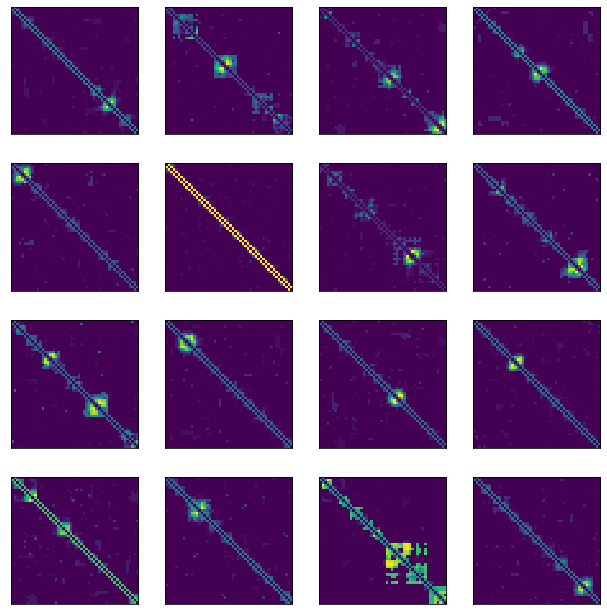

In [10]:
display_dictionary(W = W_true,
                   figsize = [10,10])

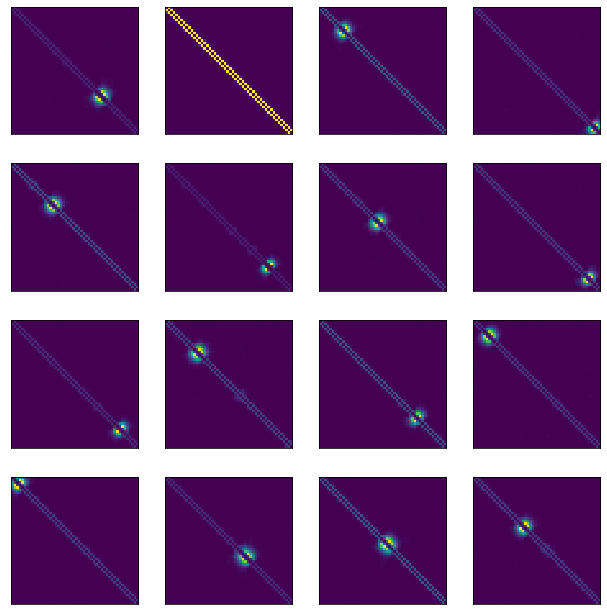

In [11]:
display_dictionary(W = W_false,
                   figsize = [10,10])

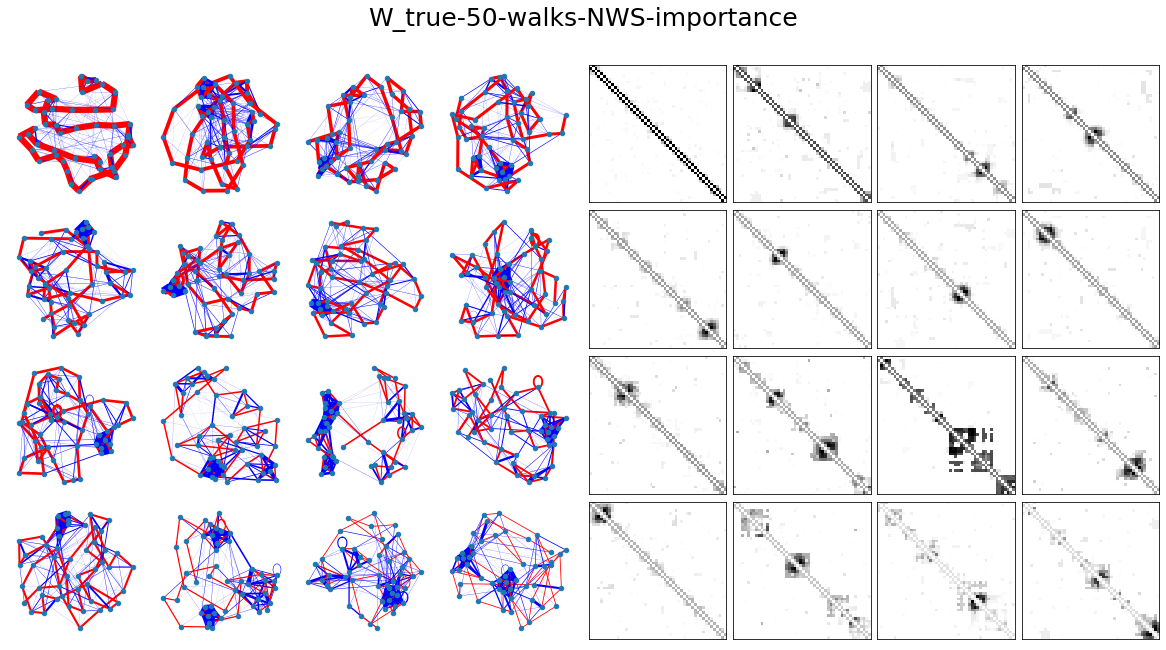

In [12]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       W = W_true, 
                       At = np.dot(H_true, H_true.T),
                       weight_graph=150,
                       fig_size=[20,10], 
                       show_importance=True)

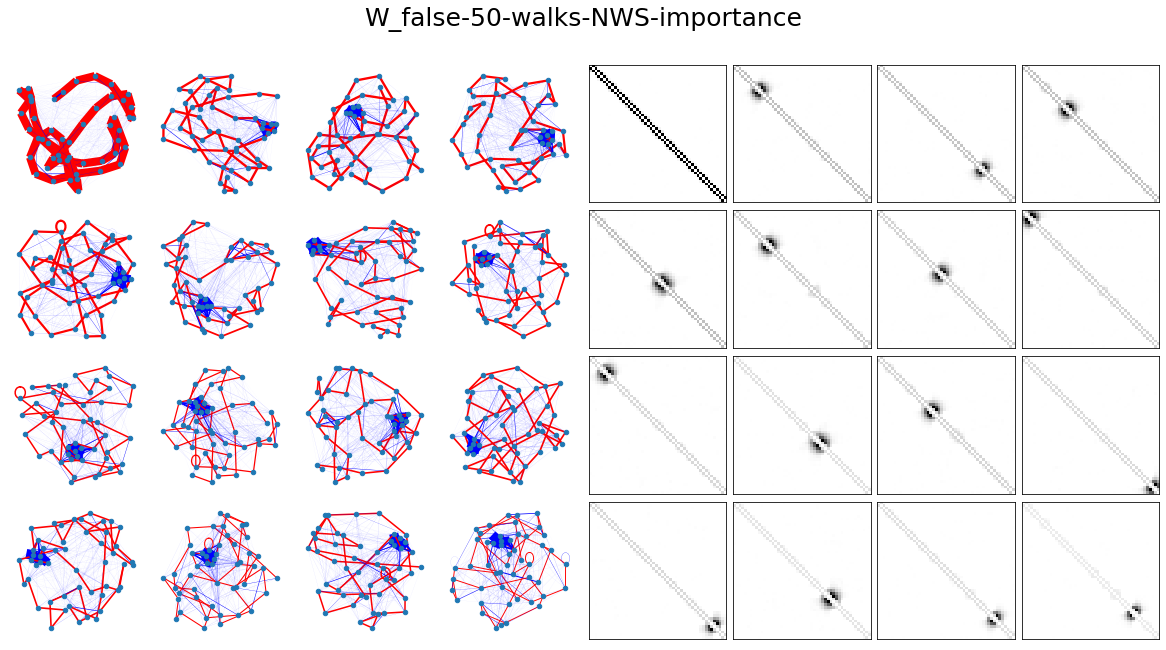

In [13]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       W=W_false, 
                       At = np.dot(H_false, H_false.T),
                       weight_graph=150,
                       fig_size=[20,10], 
                       show_importance=True)